In [2]:
import numpy as np
import pandas as pd
import glob

# declare a class for molecules
class Molecule:
    
        def __init__(self):
                data=pd.read_csv('Eref_bee.txt', sep="\t", header=0)
                sobol=pd.read_csv('sobol_samples.txt', sep="\t", header=0)
                #start by defining some physical constants
                self.R = 8.3144621E-3 #ideal Gas constant in kJ/mol-K
                self.kB = 1.38065e-23 #Boltzmann constant in J/K
                self.h = 6.62607e-34 #Planck constant in J*s
                self.c = 2.99792458e8 #speed of light in m/s
                self.amu = 1.6605e-27 #atomic mass unit in kg
                self.Avogadro = 6.0221E23 #mole^-1
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.scale_BEEF = 0.683 #scaling factor for the BEEF ensemble
                self.num_elements = 4  # C, O, H, X ##hardcoded for now
                
                self.Erefbee = {"Ni111": {"XCO":data['CO111'].to_numpy(), "XO":data['O111'].to_numpy(), "XH":np.zeros(2000), "X":data['Ni111'].to_numpy()},
                                "Ni100": {"XCO":data['CO100'].to_numpy(), "XO":data['O100'].to_numpy(), "XH":np.zeros(2000), "X":data['Ni100'].to_numpy()},
                                "Ni110": {"XCO":data['CO110'].to_numpy(), "XO":data['O110'].to_numpy(), "XH":np.zeros(2000), "X":data['Ni110'].to_numpy()},
                                "Ni211": {"XCO":data['CO211'].to_numpy(), "XO":data['O211'].to_numpy(), "XH":np.zeros(2000), "X":data['Ni211'].to_numpy()},                   
                                }

                self.molecular_mass_elements={'H': 1.01, 'C': 12.01, 'N': 14, 'O': 16}
                
                #Pt is just a surface site X. I'm too lazy to change all the files now
                self.reference_energies= {"Ni111": {"XCO":-92.868 ,"XO":-84.800, "XH": 0, "Pt":-79.348378},
                                          "Ni100": {"XCO":-89.301 ,"XO":-81.548, "XH": 0, "Pt":-75.766845},
                                          "Ni110": {"XCO":-81.954 ,"XO":-73.707, "XH": 0, "Pt":-68.400016},
                                          "Ni211": {"XCO":-91.922 ,"XO":-83.778, "XH": 0, "Pt": -78.430421},
                                         }
                
                self.reference_EOF={"Ni111": {"XCO":-231.9 ,"XO":-237.9, "XH": 0, "Pt":0},
                                    "Ni100": {"XCO":-238.8 ,"XO":-263.6, "XH": 0, "Pt":0},
                                    "Ni110": {"XCO":-240.4 ,"XO":-233.7, "XH": 0, "Pt":0},
                                    "Ni211": {"XCO":-254.3 ,"XO":-308.7, "XH": 0, "Pt":0},
                                    }

                self.reference_EOF_bee={"Ni111": {"XCO":-231.9+sobol['dh_co_111'].to_numpy(),"XO":-237.9+sobol['dh_o_111'].to_numpy(), "XH": np.zeros(2000), "X":np.zeros(2000)},
                                    "Ni100": {"XCO":-238.8 +sobol['dh_co_100'].to_numpy(),"XO":-263.6+sobol['dh_o_100'], "XH": np.zeros(2000), "X":np.zeros(2000)},
                                    "Ni110": {"XCO":-240.4 +sobol['dh_co_110'].to_numpy(),"XO":-233.7+sobol['dh_o_110'], "XH": np.zeros(2000), "X":np.zeros(2000)},
                                    "Ni211": {"XCO":-254.3 +sobol['dh_co_211'].to_numpy(),"XO":-308.7+sobol['dh_o_211'], "XH": np.zeros(2000), "X":np.zeros(2000)},
                                    }
                
                self.reference_compositions={"XCO": {"C": 1,  "O": 1, "H":0, "Pt": 1},
                                             "XO": {"C": 0, "O": 1, "H":0, "Pt": 1},
                                             "XH": {"C": 0, "O": 0, "H":1, "Pt": 1},
                                             "X": {"C": 0, "O": 0, "H":0, "Pt": 1},
                                             }                

In [3]:
def parse_input_file(inputfile, molecule):
    
    import os
    script_dir=''
    rel_path = str(script_dir) + str(inputfile)
    abs_file_path = os.path.join(rel_path)
    
    molecule.filename = str(inputfile)
    
    input_file = open(abs_file_path,'r')
    lines = input_file.readlines()
    input_file.close()
    
    error_name = True
    error_DFT_energy = True
    error_ZPE_energy = True
    error_DFT_energy_gas = True
    error_ZPE_energy_gas = True
    error_composition = True
    error_sites = True
    error_gas_BEE = True
    error_BEE = True
    error_coverage = True
    error_facet = True
    
    molecule.N_BEE=2000
    
    for line in lines:
        #start by looking for the name
        if line.strip().startswith("name"):
            bits = line.split('=')
            name = bits[1].strip().replace("'","").replace('"','')
            molecule.name = name
            error_name = False
        #now look for the DFT energy    
        elif line.strip().startswith("DFT_energy"):
            bits = line.split('=') 
            DFT_energy_info = bits[1].strip().replace("[","").replace("]","").split(',')
            DFT_energy = float(DFT_energy_info[0])
            units = DFT_energy_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.DFT_energy = DFT_energy
                molecule.DFT_energy_units = units.strip()
                error_DFT_energy = False
            else:
                print ("DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("ZPE_energy"):
            bits = line.split('=') 
            ZPE_energy_info = bits[1].strip().replace("[","").replace("]","").split(',')
            ZPE_energy = float(ZPE_energy_info[0])
            units = ZPE_energy_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.ZPE_energy = ZPE_energy
                molecule.ZPE_energy_units = units.strip()
                error_ZPE_energy = False
            else:
                print ("ZPE energy is missing proper units!\n Please use 'eV'")
                break
        #now look for the DFT energy    
        elif line.strip().startswith("gas_DFT_energy"):
            bits = line.split('=') 
            DFT_energy_gas_info = bits[1].strip().replace("[","").replace("]","").split(',')
            DFT_energy_gas = float(DFT_energy_gas_info[0])
            units = DFT_energy_gas_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.DFT_energy_gas = DFT_energy_gas
                molecule.DFT_energy_gas_units = units.strip()
                error_DFT_energy_gas = False
            else:
                print ("gas DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("gas_ZPE_energy"):
            bits = line.split('=') 
            ZPE_energy_gas_info = bits[1].strip().replace("[","").replace("]","").split(',')
            ZPE_energy_gas = float(ZPE_energy_gas_info[0])
            units = ZPE_energy_gas_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.ZPE_energy_gas = ZPE_energy_gas
                molecule.ZPE_energy_gas_units = units.strip()
                error_ZPE_energy_gas = False
            else:
                print ("gas ZPE energy is missing proper units!\n Please use 'eV'")
                break
        #now look for the composition    
        elif line.strip().startswith("composition"):
            bits = line.split('=') 
            composition = bits[1].strip().replace("{","").replace("}","").split(',')
            molecule.composition = {}
            for pair in composition:
                element, number = pair.split(":")
                element = element.strip().replace("'","").replace('"','')
                number = int(number)
                molecule.composition[element]=number
            N_adsorbate_atoms = 0
            for element in molecule.composition:
                if element!='Pt':
                    N_adsorbate_atoms += molecule.composition[element]            
            error_composition = False

        #now look for the coverage    
        elif line.strip().startswith("coverage"):
            bits = line.split('=') 
            coverage_info = bits[1].strip()
            coverage = int(coverage_info[0])
            molecule.coverage = coverage
            error_coverage = False
       
        #now look for the facet 
        elif line.strip().startswith("facet"):
            bits = line.split('=') 
            facet_info = bits[1].strip().replace("[","").replace("]","").replace("'","")
            facet = str(facet_info)
            molecule.facet = facet
            error_facet = False

        #now look for the BEE   
        elif line.strip().startswith("BEE"):
            bits = line.split('=') 
            BEE_data_info = bits[1].strip().replace("[","").replace("]","").split(',')
            BEE_data = BEE_data_info
            molecule.BEE_energies = []
            for i in range(len(BEE_data)):
                    cleaned_BEE_data = BEE_data[i].strip()
                    molecule.BEE_energies.append(float(cleaned_BEE_data))
            if len(BEE_data)==molecule.N_BEE:
                    error_BEE = False
            else:
                print ("The number of sample of the BEE is not 2000!\n Please check again!")
                break      
        #now look for the gas BEE   
        elif line.strip().startswith("gas_BEE"):
            bits = line.split('=') 
            gas_BEE_data_info = bits[1].strip().replace("[","").replace("]","").split(',')
            gas_BEE_data = gas_BEE_data_info
            molecule.gas_BEE_energies = []
            for i in range(len(gas_BEE_data)):
                    cleaned_gas_BEE_data = gas_BEE_data[i].strip()
                    molecule.gas_BEE_energies.append(float(cleaned_gas_BEE_data))

            if len(gas_BEE_data)==molecule.N_BEE:
                    error_gas_BEE = False
            else:
                print ("The number of sample of the gas BEE is not 2000!\n Please check again!")
                break          
            
    if error_name or error_DFT_energy or error_ZPE_energy or error_DFT_energy_gas or error_ZPE_energy_gas or error_composition or error_gas_BEE or error_BEE:
        print ("Input file is missing information: %s"%(inputfile))
    else:
        print ("successfully parsed file %s"%(inputfile))    
    return

def compute_thermo(molecule):

    # Fill in the elemental composition matrix of the target species
    N = np.array([molecule.composition["C"], molecule.composition["O"], molecule.composition["H"], molecule.composition["Pt"]])

    molecule.references=list(molecule.reference_compositions.keys())

    # Create a matrix to hold the elemental compositions of the reference species
    num_references = len(molecule.reference_compositions)
    N_R = np.zeros((num_references, molecule.num_elements))
    
    for s, composition in molecule.reference_compositions.items():
        i = molecule.references.index(s)
        N_R[i,:] = np.array([composition["C"], composition["O"],
                            composition["H"], composition["Pt"]])
        
    #Calculate the matrix of stoichiometric coefficients to form the target from the reference species
    molecule.M=-N.dot(np.linalg.inv(N_R)) 
    
    molecule.H_ref=np.array(list(molecule.reference_EOF[molecule.facet].values()))
    molecule.E_ref=np.array(list(molecule.reference_energies[molecule.facet].values()))
    
    molecule.E=np.array(molecule.DFT_energy+molecule.ZPE_energy)
    
    #Determine the enthalpy of formation of the target
    molecule.heat_of_formation_0K=molecule.E*molecule.eV_to_kJpermole
    molecule.heat_of_formation_0K+=molecule.M.dot(molecule.E_ref)*molecule.eV_to_kJpermole
    molecule.heat_of_formation_0K-=molecule.M.dot(molecule.H_ref)
    #print(molecule.heat_of_formation_0K)
    
    return

def compute_thermo_bee(molecule):
    compute_thermo(test)
    
    ##Calculate the binding energies for coverage dependence
    molecule.gas_energy=molecule.DFT_energy_gas+molecule.ZPE_energy_gas
    molecule.ads_energy=molecule.DFT_energy+molecule.ZPE_energy
    molecule.slab_energy=np.array(list(molecule.reference_energies[molecule.facet].values())[-1])
    
    molecule.binding_energy=1/molecule.coverage*(molecule.ads_energy-molecule.slab_energy-molecule.coverage*molecule.gas_energy)
    
    print(molecule.binding_energy)
    
    molecule.energy_bee=np.zeros(molecule.N_BEE)
    molecule.heat_of_formation_bee=np.zeros(molecule.N_BEE)
    
    molecule.delta_heat_of_formation_bee=np.zeros(molecule.N_BEE)
    
    E_ref_bee=np.zeros([molecule.num_elements,molecule.N_BEE])
    delta_E_ref_bee=np.zeros([molecule.num_elements,molecule.N_BEE])
    
    molecule.binding_energy_bee=np.zeros(molecule.N_BEE)
    
    for s, values in molecule.Erefbee[molecule.facet].items(): 
        i=molecule.references.index(s)
        E_ref_bee[i,:] = values
    
    
    H_ref_bee=np.zeros([molecule.num_elements,molecule.N_BEE])
    for s, values in molecule.reference_EOF_bee[molecule.facet].items(): 
        i=molecule.references.index(s)
        H_ref_bee[i,:] = values
        
    for j in range(molecule.N_BEE):     
            
        molecule.binding_energy_bee[j]=molecule.ads_energy-molecule.BEE_energies[j]*molecule.scale_BEEF
        molecule.binding_energy_bee[j]-=molecule.coverage*(molecule.gas_energy-molecule.gas_BEE_energies[j]*molecule.scale_BEEF) 
        molecule.binding_energy_bee[j]-= (molecule.slab_energy-E_ref_bee[3,j]*molecule.scale_BEEF)
        molecule.binding_energy_bee[j]*=1/molecule.coverage
        
        print(molecule.binding_energy_bee[j])
        
        molecule.energy_bee[j]=molecule.DFT_energy-molecule.BEE_energies[j]*molecule.scale_BEEF+molecule.ZPE_energy
        delta_E_ref_bee[:,j]=np.subtract(molecule.E_ref,E_ref_bee[:,j]*molecule.scale_BEEF)
        
        molecule.heat_of_formation_bee[j]=molecule.energy_bee[j]*molecule.eV_to_kJpermole
        molecule.heat_of_formation_bee[j]+=molecule.M.dot(delta_E_ref_bee[:,j])*molecule.eV_to_kJpermole
        molecule.heat_of_formation_bee[j]-=molecule.M.dot(H_ref_bee[:,j])
        
        molecule.delta_heat_of_formation_bee[j]=molecule.heat_of_formation_0K-molecule.heat_of_formation_bee[j]
        
        #print(np.round(molecule.heat_of_formation_bee[j],2),H_ref_bee[0,j])
        #print(molecule.reference_EOF_bee)
    
    import os
    
    script_dir='ensembles/'
    rel_path = str(molecule.facet) + '/' + molecule.name+ '_bee.txt'
    output_file_path = os.path.join(script_dir, rel_path)
    data=np.c_[molecule.heat_of_formation_bee, molecule.delta_heat_of_formation_bee]
    names=['dH','delta_dH']
    df=pd.DataFrame(data, columns=[names])
    df.to_csv(output_file_path,sep="\t", index=False)
    
    
    script_dir='ensembles/'
    rel_path = str(molecule.facet) + '/' 'CO_19_binding_energy_bee.txt'
    output_file_path = os.path.join(script_dir, rel_path)
    data=np.c_[molecule.binding_energy_bee]
    names=['Eb']
    df=pd.DataFrame(data, columns=[names])
    df.to_csv(output_file_path,sep="\t", index=False)
    
    print(rel_path)
    return


In [80]:
for filename in glob.iglob('dft-data/Ni211/CO_19.dat'):
    print(filename)
    test = Molecule()
    parse_input_file(filename,test)
    compute_thermo_bee(test)

dft-data/Ni211/CO_19.dat
successfully parsed file dft-data/Ni211/CO_19.dat
-1.5554710000000025
-1.5364056083358548
-1.482335924551201
-1.485914202165997
-1.5054539493235666
-1.7517726435457348
-1.4537776516150664
-1.7529302674718679
-1.7407530766070636
-1.5892694789160657
-1.5275520330498011
-1.4189498483715397
-1.3348821274807392
-1.7443494023916912
-1.513681791442508
-1.600269835344804
-1.6446599876803134
-1.5277730994508048
-1.2574051607750718
-1.8006945029987946
-1.6281548143966802
-1.5916488738435532
-1.3758405128446896
-1.6401278123921372
-1.6484693257330925
-1.3357262489143977
-1.4829069384251596
-1.415605318911389
-1.3835274228684895
-1.5084355458836285
-1.3116439342479964
-1.7401184947939328
-1.4154072577719372
-1.4148158706307754
-1.606467466513692
-1.6315722073430337
-1.5425393153117852
-1.5142133521064025
-1.4665614909942235
-1.6271630035996623
-1.482292158508983
-1.531620771010921
-1.627042979721466
-1.7577568357649298
-1.4555896016467074
-1.5901000358211377
-1.79552324173

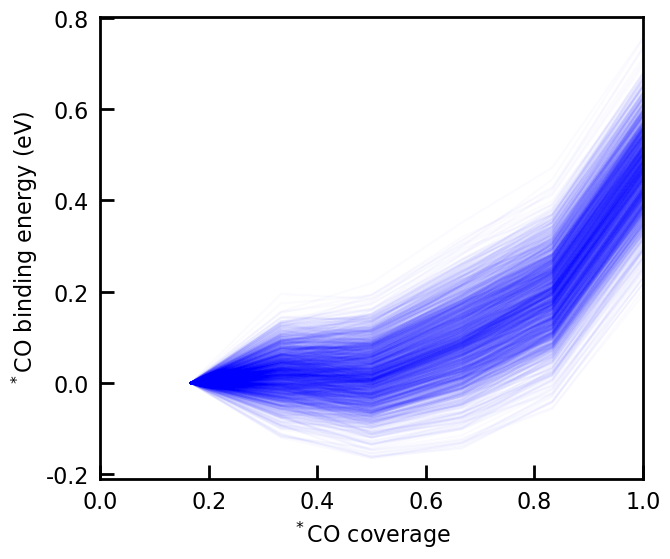

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#Makes the diagrams look nice and shiny
plt.rcParams['figure.figsize']=(7,6)
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.major.width']=2
plt.rcParams['legend.edgecolor']='k'
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['legend.handletextpad']=0.4
plt.rcParams['legend.columnspacing']=0.5
plt.rcParams['legend.labelspacing']=0.3
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['axes.formatter.limits']=(-3, 6)


co19=pd.read_csv('ensembles/Ni211/CO_19_binding_energy_bee.txt', sep="\t", header=0)
co29=pd.read_csv('ensembles/Ni211/CO_29_binding_energy_bee.txt', sep="\t", header=0)
co39=pd.read_csv('ensembles/Ni211/CO_39_binding_energy_bee.txt', sep="\t", header=0)
co49=pd.read_csv('ensembles/Ni211/CO_49_binding_energy_bee.txt', sep="\t", header=0)
co59=pd.read_csv('ensembles/Ni211/CO_59_binding_energy_bee.txt', sep="\t", header=0)
co69=pd.read_csv('ensembles/Ni211/CO_69_binding_energy_bee.txt', sep="\t", header=0)

theta_211 = np.array([1/6, 2/6, 3/6, 4/6, 5/6, 6/6])

gs=gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.3, hspace=0.2)

colormap=plt.cm.Dark2
colors = [colormap(i) for i in np.linspace(0, 1, 8)]

ax0=plt.subplot(gs[0,0])


nruns=2000
for j in range(nruns):
    ax0.plot(theta_211,np.array([co19['Eb'][j],co29['Eb'][j],co39['Eb'][j],co49['Eb'][j],co59['Eb'][j],co69['Eb'][j]])-co19['Eb'][j], marker='None',linestyle='solid', color='b',alpha=0.02)


ax0.set_ylabel('$\mathrm{^*CO\ binding\ energy\ (eV)}$')
#ax0.set_ylim([-2, -0.8])
ax0.set_xlim([0, 1])
ax0.set_xlabel('$\mathrm{^*CO\ coverage}$')

plt.savefig('CO_211_covdep_beef.png',dpi=600,transparent=False, bbox_inches='tight')